# Investigating Slow Scripts, Can we identify contributing add-ons?

Running the notebook as usual to get to our clean dataset

# E10s testing for Beta 51 week 6: Main analysis

(This covers data from 2016-12-28 to 2017-01-04 on Beta 51)

## Data processing

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
from pyspark.sql import Row

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)
seaborn.set_style('whitegrid')

from operator import add
pd.set_option("display.max_rows", None)

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

640

In [3]:
sc.version

u'1.6.1'

In [4]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data = 100 * group_data / group_data.sum()
    return group_data
    

def compare_histogram(histogram, e10s_addons, none10s_addons, e10s_std=None, none10s_std=None,
                      include_diff=True, include_diff_in_diff=True, did_separate_plot=True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    eTotal = make_group_histogram(e10s_addons)
    nTotal = make_group_histogram(none10s_addons)
    
    if include_diff:
        if include_diff_in_diff and did_separate_plot:
            fig, (ax, diff_ax, diff_diff_ax) = plt.subplots(3, sharex=True, figsize=(16,10), 
                                                            gridspec_kw={"height_ratios": [2,2,1]})
        else:
            fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    fig.subplots_adjust(hspace=0.3)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width,
                position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non-e10s", ax=ax2, width=width,
                position=1, grid=False, ylim=ax.get_ylim())
    
    ## Combine legend info from both Axes.
    ax_h, ax_l = ax.get_legend_handles_labels()
    ax2_h, ax2_l = ax2.get_legend_handles_labels()
    ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)
 
    plt.title(histogram)
    ax.xaxis.grid(False)
    ax.set_ylabel("Frequency %")

    if include_diff:
        ## Add a second barplot of the difference in frequency for each bucket.
        #diff_ax = fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        
        has_diff_in_diff_data = (e10s_std is not None and len(e10s_std) > 0 and
                                 none10s_std is not None and len(none10s_std) > 0)
        if include_diff_in_diff and has_diff_in_diff_data:
            ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
            ## The assumption is that the difference between addons cohorts would look the same
            ## if there is no additional effect of having addons.
            eTotal_std = make_group_histogram(e10s_std)
            nTotal_std = make_group_histogram(none10s_std)
            enDiff_std = eTotal_std - nTotal_std
            ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
            diff_ax2 = diff_ax.twinx()
            
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax, width=width,
                        position=1, ylim=ylims)
            enDiff_std.plot(kind="bar", alpha=0.5, color="gray", label="no add-ons", ax=diff_ax2, width=width,
                        position=0, grid=False, ylim=diff_ax.get_ylim())

            ## Combine legend info from both Axes.
            diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
            diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
            leg_h = diff_ax_h + diff_ax2_h
            leg_l = diff_ax_l + diff_ax2_l
            
            if did_separate_plot:
                enDiffDiff = enDiff - enDiff_std
                enDiffDiff.plot(kind="bar", alpha=0.5, color="maroon", ax=diff_diff_ax, ylim=diff_ax.get_ylim())
                diff_diff_ax.xaxis.grid(False)
                diff_diff_ax.set_ylabel("Diff in freq %")
                diff_diff_ax.set_title("Diff between e10s/non diff with add-ons and e10s/non diff without" +
                                      " (with add-ons higher when > 0)")
            
        else:
            if include_diff_in_diff:
                ## We wanted to do the additional comparison, but there wasn't enough data.
                print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax)
            leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        diff_ax.xaxis.grid(False)
        diff_ax.set_ylabel("Diff in frequency %")
        diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
    # Only display at most 100 tick labels on the x axis.
    xticklabs = plt.gca().get_xticklabels()
    max_x_ticks = 100
    if len(xticklabs) > max_x_ticks:
        step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
        for i, tl in enumerate(xticklabs):
            if i % step_size != 0:
                tl.set_visible(False)
    plt.show()
    
    ## Compute a p-value for the chi-square distance between the groups' combined histograms.
    pvalue = grouped_permutation_test(chi2_distance, [e10s_addons, none10s_addons], num_samples=100)
    print("The probability that the distributions for {} (with add-ons) are differing by chance is {:.3f}."\
          .format(histogram, pvalue))

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "e10s", "addons")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())
    
    e10s = frame[frame["addons"] & frame["e10s"]]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["addons"] & ~frame["e10s"]]
    none10s = normalize_uptime_hour(none10s)
    
    include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
    if include_diff_in_diff:
        e10s_std = normalize_uptime_hour(frame[~frame["addons"] & frame["e10s"]])
        none10s_std = normalize_uptime_hour(frame[~frame["addons"] & ~frame["e10s"]])        
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for count histogram {} (with add-ons):".format(hist_str))
        
        e10s_hist = e10s[histogram].dropna()
        non_e10s_hist = none10s[histogram].dropna()
        
        ## Print some information on sample sizes.
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(len(non_e10s_hist), cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(len(e10s_hist), cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if len(non_e10s_hist) == 0 or len(e10s_hist) == 0:
            continue
        
        print("")
        compare_scalars(hist_name + " per hour", e10s_hist, non_e10s_hist,
                        e10s_std[histogram].dropna() if include_diff_in_diff else None,
                        none10s_std[histogram].dropna() if include_diff_in_diff else None)
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s", "addons") , with_processes=True)\
        .collect())
    ## The addons experiment cohorts.
    e10s_addons = frame[frame["addons"] & frame["e10s"]]
    none10s_addons = frame[frame["addons"] & ~frame["e10s"]]
    ## The standard experiment cohorts.
    e10s_std = frame[~frame["addons"] & frame["e10s"]]
    none10s_std = frame[~frame["addons"] & ~frame["e10s"]]
    
    for histogram in histogram_names:
        if histogram not in none10s_addons.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {} (with add-ons):".format(hist_str))
        
        ## Compare the main histogram for non-e10s against each of 3 for e10s.
        addons_hist_data = {
            "non_e10s": none10s_addons[histogram],
            "e10s_merged": e10s_addons[histogram],
            "e10s_parent": e10s_addons[histogram + "_parent"],
            "e10s_children": e10s_addons[histogram + "_children"]
        }
        for htype in addons_hist_data:
            addons_hist_data[htype] = addons_hist_data[htype].dropna()
        
        ## Print some information on sample sizes.
        sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["non_e10s"], cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["e10s_merged"], cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if sample_sizes["non_e10s"] == 0 or sample_sizes["e10s_merged"] == 0:
            continue
        
        print("{} e10s profiles have the parent histogram.".format(
                sample_size_str(sample_sizes["e10s_parent"], cohort_sizes.get("addons-set2a-test"))))
        print("{} e10s profiles have the children histogram.".format(
                sample_size_str(sample_sizes["e10s_children"], cohort_sizes.get("addons-set2a-test"))))
        
        has_parent = sample_sizes["e10s_parent"] > 0
        has_children = sample_sizes["e10s_children"] > 0
        
        non_e10s_std_hist = none10s_std[histogram].dropna()
        
        ## Compare merged histograms, unless e10s group has either no parents or no children.
        if has_children and has_parent:
            compare_histogram(hist_name + " (e10s merged)", 
                              addons_hist_data["e10s_merged"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram].dropna(),
                              non_e10s_std_hist,
                              **kwargs)
        
        if has_parent:
            compare_histogram(hist_name + " (parent)",
                              addons_hist_data["e10s_parent"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_parent"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

        if has_children:
            compare_histogram(hist_name + " (children)",
                              addons_hist_data["e10s_children"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_children"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

def compare_scalars(metric, e10s_data, non_e10s_data, e10s_std=None, non_e10s_std=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    e10s_data = e10s_data.dropna()
    non_e10s_data = non_e10s_data.dropna()
    if len(e10s_data) == 0 or len(non_e10s_data) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        return
    
    print("Comparison for {}{} (with add-ons):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))
    e10s_median = np.median(e10s_data)
    non_e10s_median = np.median(non_e10s_data)
    mdiff = median_diff(e10s_data, non_e10s_data)
    print("- Median with e10s is {:.3g} {} {} median without e10s."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / non_e10s_median * 100))
    print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}.".format(e10s_median, non_e10s_median))
            
    print("\nThe probability of this difference occurring purely by chance is {:.3f}."\
        .format(grouped_permutation_test(median_diff, [e10s_data, non_e10s_data], num_samples=10000)))
    
    if e10s_std is not None and non_e10s_std is not None:
        ## Include a comparison between non-addon cohorts.
        e10s_std = e10s_std.dropna()
        non_e10s_std = non_e10s_std.dropna()
        if len(e10s_std) > 0 and len(non_e10s_std) > 0:
            non_e10s_std_median = np.median(non_e10s_std)
            mdiff_std = median_diff(e10s_std, non_e10s_std)
            print("\nFor cohorts with no add-ons, median with e10s is {:.3g} {} ({:.1f}%) {} median without"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / non_e10s_std_median * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))

    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
        However, if the histogram is keyed, and specified with a key, return
        [histname, key].
    """
    path_to_histogram = path_to_histogram.rsplit("/")
    if len(path_to_histogram) > 1 and path_to_histogram[-3] == "keyedHistograms":
        ## There was a keyedHistogram name and key given.
        return path_to_histogram[-2:]
    return path_to_histogram[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 50 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [5]:
# regenerated data and loaded into telemetry-test-bucket
dataset = sqlContext.read.parquet(
    "s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta51_cohorts/v20161228_20170104/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [6]:
dataset.count()

2922783

In [66]:
def get_slow_scripts(hist):
    """
    Look for the slow script hist in a ping's histograms
    return the sum of that hist if its present otherwise
    return -1
    """
    if hist:
        hist = json.loads(hist)
        if 'SLOW_SCRIPT_PAGE_COUNT' in hist:
            return int(hist['SLOW_SCRIPT_PAGE_COUNT']['sum'])
    return -1

get_slow_scripts = fun.udf(get_slow_scripts, pyspark.sql.types.IntegerType())

addons_dataset = dataset.filter("e10sCohort like 'addons-set51%'")\
                        .withColumn('slow_scripts', get_slow_scripts('histograms'))

addons_dataset_slow = addons_dataset.filter("slow_scripts > -1")
addons_dataset_no_slow = addons_dataset.filter("slow_scripts = -1")

addons_dataset_slow.count(), addons_dataset_no_slow.count()

(12669, 1017795)

In [165]:
def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem")) for guid, meta in addons.iteritems()]


def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys), n): (guid, (name, sys, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, n)): (guid, (name, sys)))
    n_installs = addon_counts.mapValues(lambda (name, sys, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else \
                      addon_info.takeOrdered(n_top, key=lambda x: -x['n_installs'])
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "is_system", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)


def get_top_addons(data, n_top=50):
    addons_cohort_num, addons_cohort_table = dataset_installed_addons(data,n_top=n_top)
    addons_cohort_table["n_installs"] = addons_cohort_table["n_installs"].map("{:,}".format)
    addons_cohort_table["pct_installed"] = addons_cohort_table["pct_installed"].map("{:.2f}".format)
    return addons_cohort_table

# A look at Slow Scripts

In [166]:
top_slow = get_top_addons(addons_dataset_slow)
top_no_slow = get_top_addons(addons_dataset_no_slow)

Identify which, if any, guids appear in the top 50 add-ons among pings *with* slow scrips versus pings without. 

In [167]:
distinct_to_slow = set(top_slow.guid) - set(top_no_slow.guid)

Associated data with these guids

In [168]:
top_slow[[i in distinct_to_slow for i in top_slow.guid]]

,guid,name,is_system,n_installs,pct_installed
33,jid1-YcMV6ngYmQRA2w@jetpack,Pin It button,False,184,1.45
34,87677a2c52b84ad3a151a4a72f5bd3c4@jetpack,Grammarly for Firefox,False,182,1.44
44,sovetnik@metabar.ru,Советник Яндекс.Маркета,False,155,1.22
46,yasearch@yandex.ru,Элементы Яндекса,False,144,1.14
48,{bee6eb20-01e0-ebd1-da83-080329fb9a3a},Flash and Video Download,False,139,1.10


Ok, lets took at the slow script distribution for pings with these add-ons versus pings without them

In [169]:
def has_bad(addons):
    addons = json.loads(addons).get('activeAddons', {})
    if distinct_to_slow - set(addons.keys()) != distinct_to_slow:
        return True
    return False


has_bad = fun.udf(has_bad, pyspark.sql.types.BooleanType())
ss_test = addons_dataset_slow.filter(has_bad('addons')).select('slow_scripts').collect()
ss_control = addons_dataset_slow.filter(~has_bad('addons')).select('slow_scripts').collect()

In [170]:
len(ss_test), len(ss_control)

(710, 11959)

In [171]:
ss_test = map(lambda x: x.slow_scripts, ss_test)
ss_control = map(lambda x: x.slow_scripts, ss_control)

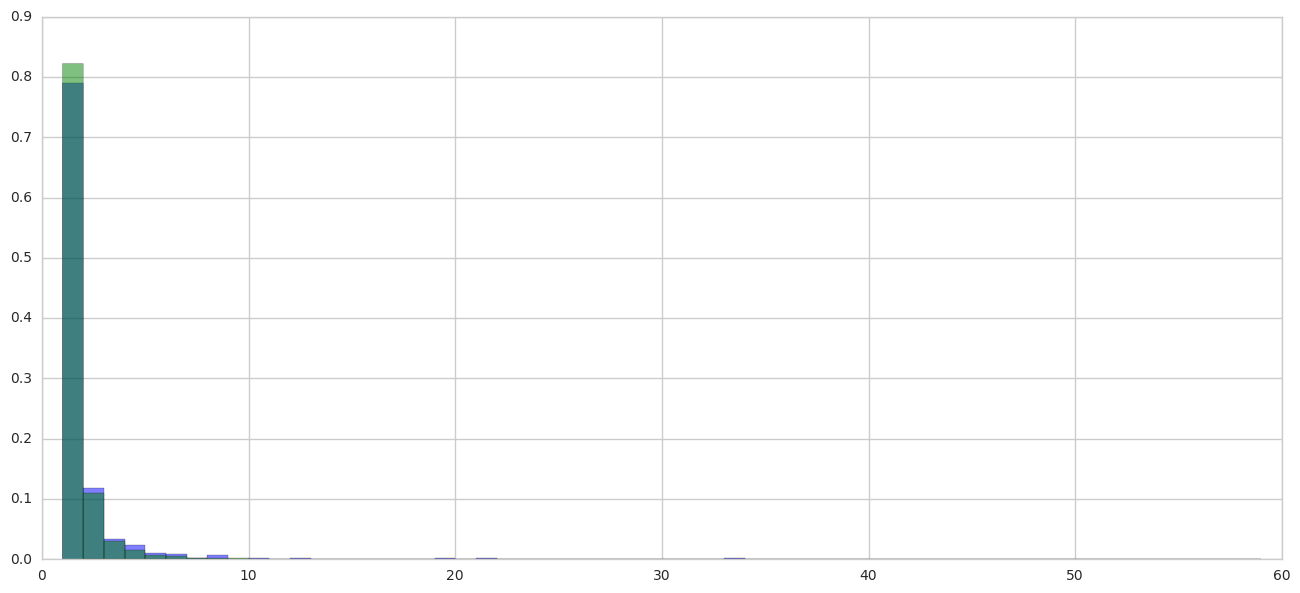

In [172]:
plt.hist(ss_test, color='blue', alpha=.5, normed=True, bins=range(1, 60))
plt.hist(ss_control, color='green', alpha=.5, normed=True, bins=range(1, 60))
plt.show()

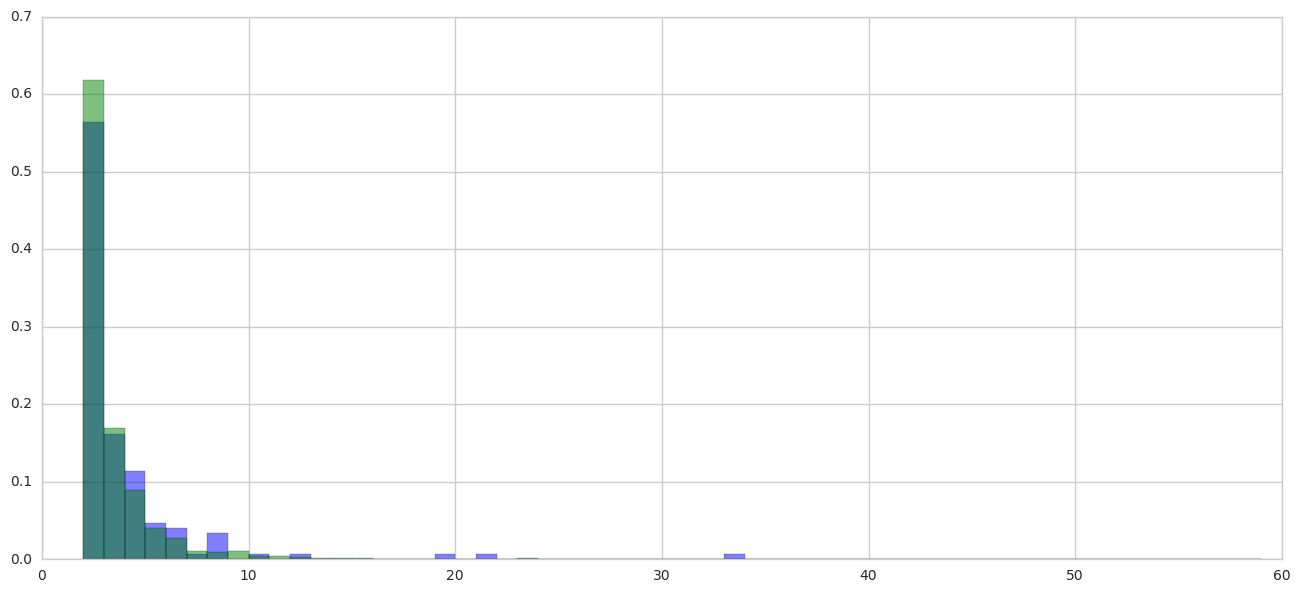

In [173]:
ss_test = [i for i in ss_test if i > 1]
ss_control = [i for i in ss_control if i > 1]

plt.hist(ss_test, color='blue', alpha=.5, normed=True, bins=range(1, 60))
plt.hist(ss_control, color='green', alpha=.5, normed=True, bins=range(1, 60))
plt.show()